In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Input, Dense, Dropout
from keras import Model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import figure_factory as figfactory


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis - Final/Gold Futures Historical Data.csv')

In [ ]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2933 non-null   object
 1   Price     2933 non-null   object
 2   Open      2933 non-null   object
 3   High      2933 non-null   object
 4   Low       2933 non-null   object
 5   Vol.      2929 non-null   object
 6   Change %  2933 non-null   object
dtypes: object(7)
memory usage: 160.5+ KB


,Date,Price,Open,High,Low,Vol.,Change %
0,08/21/2024,"2,550.10","2,551.10","2,557.90","2,542.60",NaN,-0.02%
1,08/20/2024,"2,550.60","2,542.40","2,570.40","2,535.10",191.20K,0.37%
2,08/19/2024,"2,541.30","2,549.70","2,549.90","2,523.70",155.99K,0.14%
3,08/16/2024,"2,537.80","2,494.40","2,548.30","2,488.20",223.93K,1.82%
4,08/15/2024,"2,492.40","2,486.20","2,508.00","2,469.20",169.32K,0.51%


In [ ]:
figure = figfactory.create_table(df.head(n = 10))
figure.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2933 non-null   object
 1   Price     2933 non-null   object
 2   Open      2933 non-null   object
 3   High      2933 non-null   object
 4   Low       2933 non-null   object
 5   Vol.      2929 non-null   object
 6   Change %  2933 non-null   object
dtypes: object(7)
memory usage: 160.5+ KB


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Drop unnecessary columns
columns_to_drop = ['Vol.', 'Change %']
df = df[[col for col in df.columns if col not in columns_to_drop]]

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Clean numeric columns
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

# Define the size of the test set based on the year 2022
test_size = df[df['Date'].dt.year == 2023].shape[0]

# Initialize MinMaxScaler and fit it on the entire dataset
price_scaler = MinMaxScaler()
price_scaler.fit(df['Price'].values.reshape(-1, 1))

window_size = 60

# Split data into train and test for each model
# LSTM
train_data_lstm = df[df['Date'].dt.year < 2018]['Price']
test_data_lstm = df[df['Date'].dt.year == 2022]['Price']

# Scale the data
train_data_lstm = price_scaler.transform(train_data_lstm.values.reshape(-1, 1))
test_data_lstm = price_scaler.transform(test_data_lstm.values.reshape(-1, 1))

# Create training windows for LSTM
X_train_lstm = []
y_train_lstm = []
for i in range(window_size, len(train_data_lstm)):
    X_train_lstm.append(train_data_lstm[i-window_size:i, 0])
    y_train_lstm.append(train_data_lstm[i, 0])

# Create testing windows for LSTM
X_test_lstm = []
y_test_lstm = []
for i in range(window_size, len(test_data_lstm)):
    X_test_lstm.append(test_data_lstm[i-window_size:i, 0])
    y_test_lstm.append(test_data_lstm[i, 0])

# Convert lists to numpy arrays for LSTM
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)
X_test_lstm = np.array(X_test_lstm)
y_test_lstm = np.array(y_test_lstm)

# Reshape for LSTM (if needed)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
y_train_lstm = np.reshape(y_train_lstm, (-1, 1))
y_test_lstm = np.reshape(y_test_lstm, (-1, 1))

# Random Forest
train_data_rf = df[df['Date'].dt.year < 2019]['Price']
test_data_rf = df[df['Date'].dt.year == 2023]['Price']

# Scale the data
train_data_rf = price_scaler.transform(train_data_rf.values.reshape(-1, 1))
test_data_rf = price_scaler.transform(test_data_rf.values.reshape(-1, 1))

# Create training windows for Random Forest
X_train_rf = []
y_train_rf = []
for i in range(window_size, len(train_data_rf)):
    X_train_rf.append(train_data_rf[i-window_size:i, 0])
    y_train_rf.append(train_data_rf[i, 0])

# Create testing windows for Random Forest
X_test_rf = []
y_test_rf = []
for i in range(window_size, len(test_data_rf)):
    X_test_rf.append(test_data_rf[i-window_size:i, 0])
    y_test_rf.append(test_data_rf[i, 0])

# Convert lists to numpy arrays for Random Forest
X_train_rf = np.array(X_train_rf)
y_train_rf = np.array(y_train_rf)
X_test_rf = np.array(X_test_rf)
y_test_rf = np.array(y_test_rf)

# Linear Regression
train_data_lr = df[df['Date'].dt.year < 2014]['Price']
test_data_lr = df[df['Date'].dt.year == 2024]['Price']

# Scale the data
train_data_lr = price_scaler.transform(train_data_lr.values.reshape(-1, 1))
test_data_lr = price_scaler.transform(test_data_lr.values.reshape(-1, 1))

# Create training windows for Linear Regression
X_train_lr = []
y_train_lr = []
for i in range(window_size, len(train_data_lr)):
    X_train_lr.append(train_data_lr[i-window_size:i, 0])
    y_train_lr.append(train_data_lr[i, 0])

# Create testing windows for Linear Regression
X_test_lr = []
y_test_lr = []
for i in range(window_size, len(test_data_lr)):
    X_test_lr.append(test_data_lr[i-window_size:i, 0])
    y_test_lr.append(test_data_lr[i, 0])

# Convert lists to numpy arrays for Linear Regression
X_train_lr = np.array(X_train_lr)
y_train_lr = np.array(y_train_lr)
X_test_lr = np.array(X_test_lr)
y_test_lr = np.array(y_test_lr)

# Print new dates for validation
train_end_date = df[df['Date'].dt.year < 2019]['Date'].max()
test_start_date = df[df['Date'].dt.year == 2023]['Date'].min()

print("Training data end date:", train_end_date)
print("Testing data start date:", test_start_date)


Training data end date: 2018-12-31 00:00:00
Testing data start date: 2023-01-03 00:00:00


In [60]:
# Assuming 'df' is your original DataFrame and you have a 'Date' column

# Extract years from the original DataFrame for train and test sets
train_years = df[df['Date'].dt.year < 2022]['Date'].dt.year.unique()
test_years = df[df['Date'].dt.year == 2022]['Date'].dt.year.unique()

# Print the years present in train and test data
print("Years in Training Data:", train_years)
print("Years in Testing Data:", test_years)


Years in Training Data: [2013 2014 2015 2016 2017 2018 2019 2020 2021]
Years in Testing Data: [2022]


In [ ]:
columns_to_drop = ['Vol.', 'Change %']
df = df[[col for col in df.columns if col not in columns_to_drop]]


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')



In [ ]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1688.8,1676.4,1695.4,1670.9
1,2013-01-03,1674.6,1686.2,1690.5,1661.2
2,2013-01-04,1648.9,1663.8,1664.5,1626.0
3,2013-01-07,1646.3,1656.3,1663.0,1642.6
4,2013-01-08,1662.2,1647.6,1662.7,1646.8


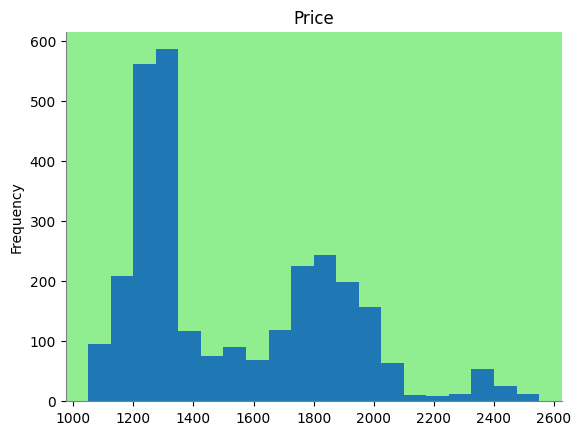

In [ ]:
# @title Price

from matplotlib import pyplot as plt
df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.duplicated().sum()
df.isnull().sum().sum()

0

In [ ]:
import plotly.express as px

# Data Visualization with Plotly
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='blue')
fig.update_layout(xaxis_title="Year",
                  yaxis_title="Gold Price",
                  title={'text': "Historical Gold Price Trends", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(173,216,230,0.8)')


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

251

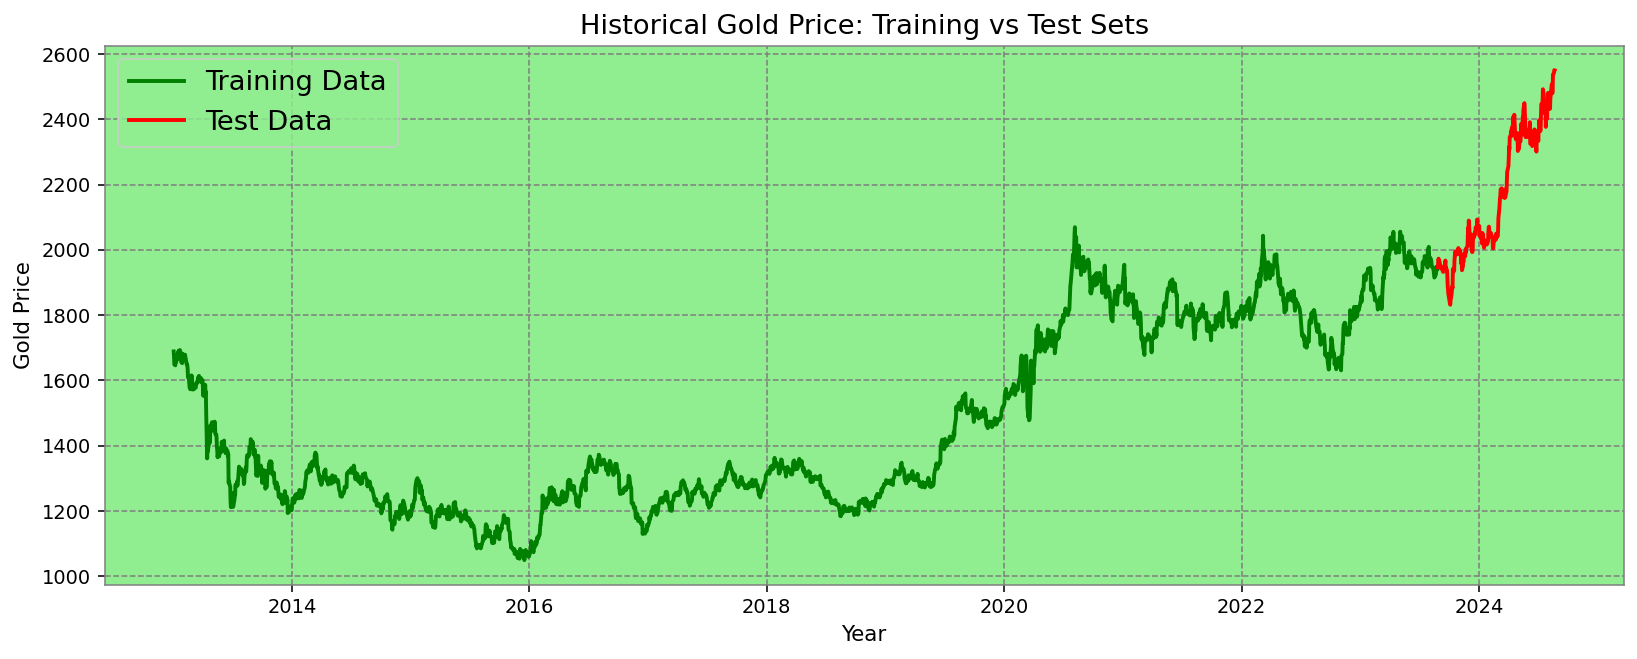

In [ ]:
import matplotlib.pyplot as plt

# Data Visualization with Matplotlib
plt.figure(figsize=(14, 5), dpi=140)
plt.rcParams['axes.facecolor'] = 'lightgreen'
plt.rc('axes', edgecolor='gray')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='green', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='red', lw=2)
plt.title('Historical Gold Price: Training vs Test Sets', fontsize=14)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Gold Price', fontsize=11)
plt.legend(['Training Data', 'Test Data'], loc='upper left', prop={'size': 14})
plt.grid(color='gray', linestyle='--')
plt.show()


In [ ]:
price_scaler = MinMaxScaler()
price_scaler.fit(df['Price'].values.reshape(-1, 1))



MinMaxScaler()

In [ ]:
window_size = 60


In [ ]:
train_data = df.Price[:-test_size]
train_data = price_scaler.transform(train_data.values.reshape(-1,1))

In [ ]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
test_data = df.Price[-test_size-60:]
test_data = price_scaler.transform(test_data.values.reshape(-1,1))

In [ ]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2208, 60, 1)
y_train Shape:  (2208, 1)
X_test Shape:   (191, 60, 1)
y_test Shape:   (191, 1)


In [ ]:
#new model 23 aug version
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def define_model(window_size):
    input1 = Input(shape=(window_size, 1))

    x = LSTM(units=128, return_sequences=True)(input1)
    x = Dropout(0.3)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)  # Add BatchNormalization to stabilize learning

    dnn_output = Dense(1)(x)  # Output layer for regression

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    model.summary()

    return model



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def define_model(window_size):
    input1 = Input(shape=(window_size, 1))

    x = LSTM(units=128, return_sequences=True)(input1)
    x = Dropout(0.3)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)  # Add BatchNormalization to stabilize learning

    dnn_output = Dense(1)(x)  # Output layer for regression

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.001))
    model.summary()

    return model


In [ ]:
# Define the model
model = define_model(window_size=60)

# Add early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,305 (1.29 MB)

 Trainable params: 338,177 (1.29 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step - loss: 0.0247 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0013 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - loss: 0.0011 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - loss: 7.8392e-04 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 7.1024e-04 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - loss: 5.9296e-04 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - loss: 7.5630e-04 - val_loss: 0.0104 - learning_rate: 5.0000e-04
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 6.1405e-04 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 9/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - loss: 5.8969e-04 - val_lo

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def define_model(window_size):
    input1 = Input(shape=(window_size, 1))

    x = LSTM(units=128, return_sequences=True)(input1)
    x = Dropout(0.5)(x)  # Increased dropout
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.5)(x)  # Increased dropout
    x = LSTM(units=128)(x)
    x = Dropout(0.5)(x)  # Increased dropout

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.0005))  # Lower learning rate
    model.summary()

    return model

# Define the model
model = define_model(window_size=60)

# Add early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,305 (1.29 MB)

 Trainable params: 338,177 (1.29 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - loss: 0.0235 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - loss: 0.0016 - val_loss: 6.1872e-04 - learning_rate: 5.0000e-04
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - loss: 0.0012 - val_loss: 8.1955e-04 - learning_rate: 5.0000e-04
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - loss: 9.7869e-04 - val_loss: 8.4441e-04 - learning_rate: 5.0000e-04
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - loss: 0.0010 - val_loss: 7.5967e-04 - learning_rate: 5.0000e-04
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - loss: 7.5141e-04 - val_loss: 7.8765e-04 - learning_rate: 5.0000e-04
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - loss: 6.4663e-04 - val_loss: 6.9823e-04 - learning_rate: 5.0000e-04
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - loss: 6.7448e-04 - val_loss: 7.6863e-04 - learning_rate: 2.5000e-04
Epoch 9/150
34/34 ━━━━━━━━━━━

In [ ]:
result = model.evaluate(X_test_lstm, y_test_lstm)
y_pred = model.predict(X_test_lstm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1334
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


In [ ]:
print(X_test_lstm.shape)


(190, 60, 1)


**with MSE**

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0198
Test Loss (MSE): 0.017226317897439003
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step
Test Mean Squared Error (MSE): 0.017226318609378868
Test Accuracy (1-MSE): 98.28%
Test Root Mean Squared Error (RMSE): 0.13124907088958332
Test R² Score: -4.344586137325508
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
Train Mean Squared Error (MSE): 0.0003041453549850037
Train Accuracy (1-MSE): 99.97%
Train Root Mean Squared Error (RMSE): 0.017439763616087338
Train R² Score: 0.9007023714468025


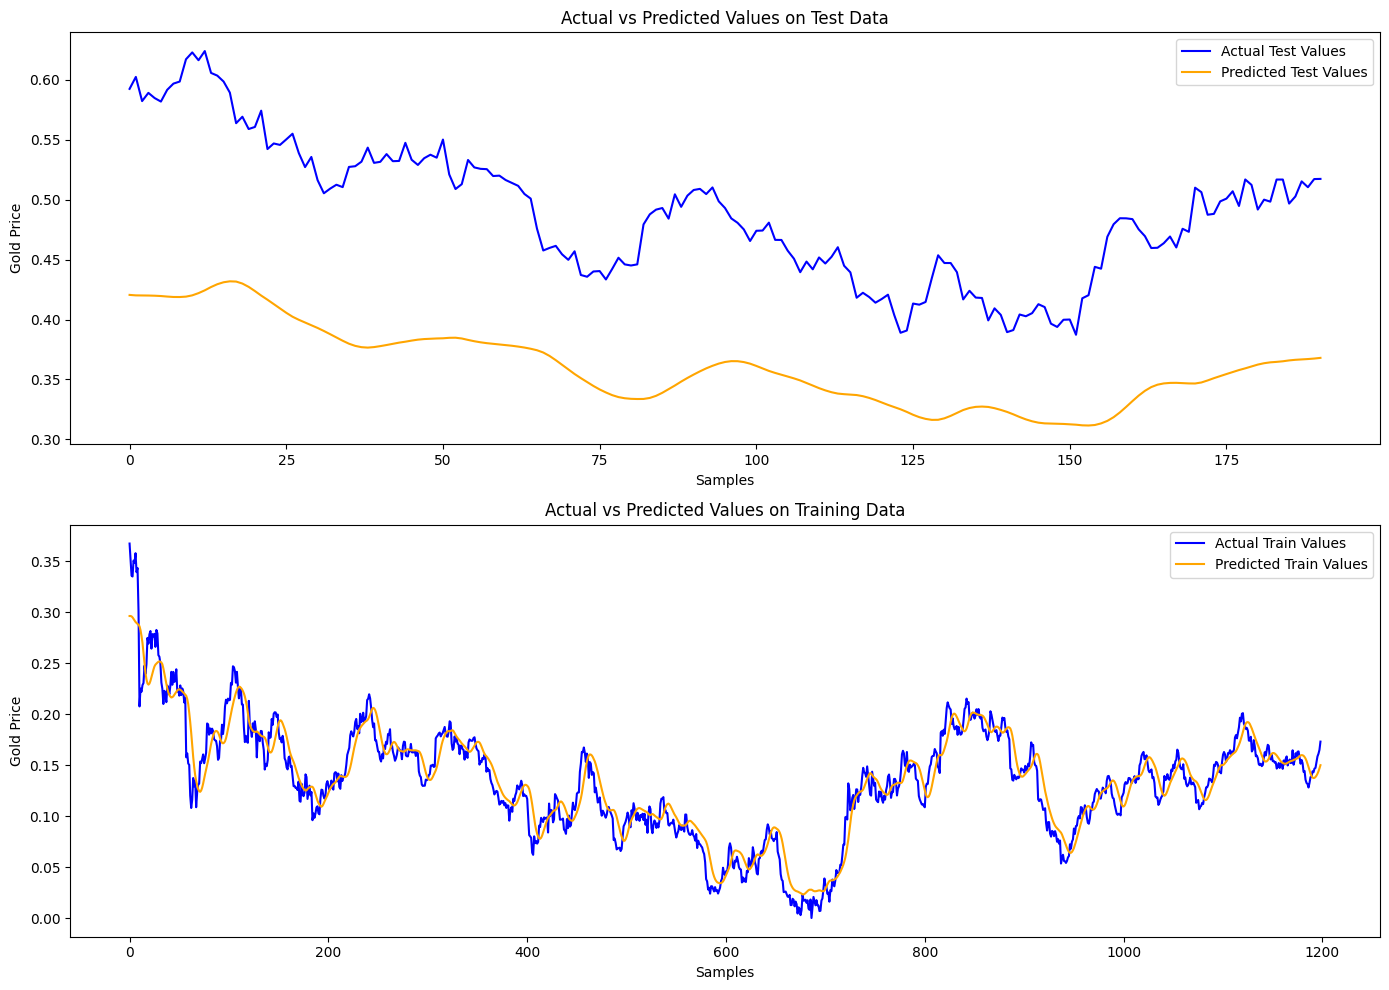

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Evaluate the Model on Test Data
test_loss = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

# 2. Make Predictions on Test Data
y_test_pred = model.predict(X_test_lstm)

# 3. Calculate Test Metrics
test_mse = mean_squared_error(y_test_lstm, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_accuracy = 1 - test_mse
test_r2 = r2_score(y_test_lstm, y_test_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Accuracy (1-MSE): {test_accuracy * 100:.2f}%")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test R² Score: {test_r2}")

# 4. Make Predictions on Training Data
y_train_pred = model.predict(X_train_lstm)

# 5. Calculate Training Metrics
train_mse = mean_squared_error(y_train_lstm, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_accuracy = 1 - train_mse
train_r2 = r2_score(y_train_lstm, y_train_pred)
print(f"Train Mean Squared Error (MSE): {train_mse}")
print(f"Train Accuracy (1-MSE): {train_accuracy * 100:.2f}%")
print(f"Train Root Mean Squared Error (RMSE): {train_rmse}")
print(f"Train R² Score: {train_r2}")

# 6. Visualize the Results
plt.figure(figsize=(14, 10))

# Plot Test Data
plt.subplot(2, 1, 1)
plt.plot(y_test_lstm, label='Actual Test Values', color='blue')
plt.plot(y_test_pred, label='Predicted Test Values', color='orange')
plt.title('Actual vs Predicted Values on Test Data')
plt.xlabel('Samples')
plt.ylabel('Gold Price')
plt.legend()

# Plot Train Data
plt.subplot(2, 1, 2)
plt.plot(y_train_lstm, label='Actual Train Values', color='blue')
plt.plot(y_train_pred, label='Predicted Train Values', color='orange')
plt.title('Actual vs Predicted Values on Training Data')
plt.xlabel('Samples')
plt.ylabel('Gold Price')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def check_for_overfitting(train_mse, test_mse, train_r2, test_r2):
    print("\n=== Overfitting Check ===")
    if test_mse > train_mse and train_r2 > test_r2:
        print("Potential Overfitting Detected:")
        print(f"- Test MSE is higher than Train MSE by {test_mse - train_mse:.6f}")
        print(f"- Train R² is higher than Test R² by {train_r2 - test_r2:.6f}")
    else:
        print("No significant overfitting detected.")
check_for_overfitting(train_mse, test_mse, train_r2, test_r2)



=== Overfitting Check ===
Potential Overfitting Detected:
- Test MSE is higher than Train MSE by 0.016922
- Train R² is higher than Test R² by 5.245289


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(X_train_lstm)):
    print(f"Fold {fold + 1}:")

    # Splitting the data based on the current fold
    X_train_fold, X_test_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_test_fold = y_train_lstm[train_index], y_train_lstm[test_index]

    # Fit the model
    model.fit(X_train_fold, y_train_fold)

    # Predict on the test set
    y_test_pred_fold = model.predict(X_test_fold)

    # Calculate metrics
    test_mse_fold = mean_squared_error(y_test_fold, y_test_pred_fold)
    test_rmse_fold = np.sqrt(test_mse_fold)
    test_r2_fold = r2_score(y_test_fold, y_test_pred_fold)

    print(f"Test MSE: {test_mse_fold}")
    print(f"Test RMSE: {test_rmse_fold}")
    print(f"Test R² Score: {test_r2_fold}")
    print("-" * 30)



Fold 1:
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0041
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Test MSE: 0.00019140199851089767
Test RMSE: 0.013834811112223313
Test R² Score: 0.7266066069609198
------------------------------
Fold 2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - loss: 0.0020
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Test MSE: 0.00023876066393648391
Test RMSE: 0.015451882213390184
Test R² Score: 0.7183413870152523
------------------------------
Fold 3:
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - loss: 7.6265e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Test MSE: 0.00025608283883538546
Test RMSE: 0.01600258850421973
Test R² Score: 0.8895661567943315
------------------------------
Fold 4:
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - loss: 6.5255e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test MSE: 0.0002985532193677477
Test RMSE: 0.017278692640583307
Test R² Score: 0.8442964714345991
------------------------------
Fold 5:
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - loss: 5.3968e-0

New code to to display training and testing accuracy on LSTM

Random Forest Model Train MSE: 0.0000
Random Forest Model Test MSE: 0.0755
Random Forest Model Train RMSE: 0.0033
Random Forest Model Test RMSE: 0.2747
Random Forest Model Train Accuracy (1-MSE): 100.00%
Random Forest Model Test Accuracy (1-MSE): 92.45%


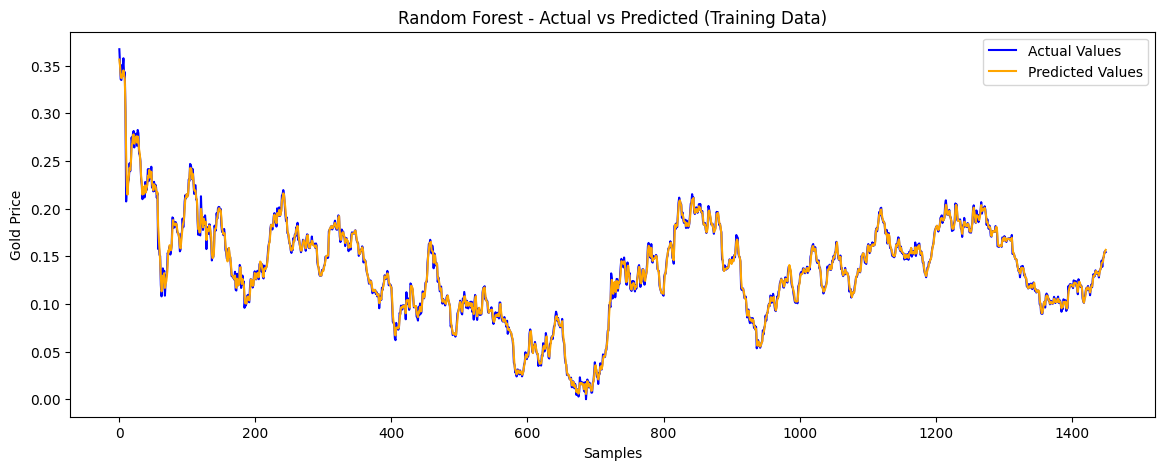

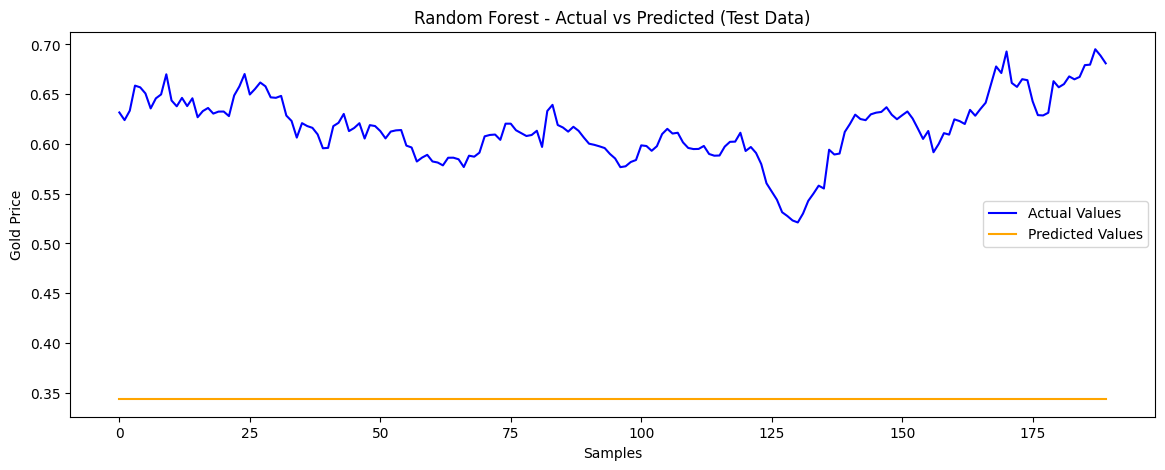

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf.ravel())
rf_predictions_train = rf_model.predict(X_train_rf)
rf_predictions_test = rf_model.predict(X_test_rf)


# Calculate MSE and RMSE
rf_mse_train = mean_squared_error(y_train_rf, rf_predictions_train)
rf_mse_test = mean_squared_error(y_test_rf, rf_predictions_test)


rf_rmse_train = np.sqrt(rf_mse_train)
rf_rmse_test = np.sqrt(rf_mse_test)


# Calculate Accuracy based on MSE
rf_accuracy_train = 1 - rf_mse_train
rf_accuracy_test = 1 - rf_mse_test


rf_accuracy_train_percentage = rf_accuracy_train * 100
rf_accuracy_test_percentage = rf_accuracy_test * 100


# Print results
print(f"Random Forest Model Train MSE: {rf_mse_train:.4f}")
print(f"Random Forest Model Test MSE: {rf_mse_test:.4f}")
print(f"Random Forest Model Train RMSE: {rf_rmse_train:.4f}")
print(f"Random Forest Model Test RMSE: {rf_rmse_test:.4f}")
print(f"Random Forest Model Train Accuracy (1-MSE): {rf_accuracy_train_percentage:.2f}%")
print(f"Random Forest Model Test Accuracy (1-MSE): {rf_accuracy_test_percentage:.2f}%")

# Visualize the Actual vs Predicted Values for Training and Test Data
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='orange')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.show()

# Plot for Random Forest
plot_predictions(y_train_rf, rf_predictions_train, 'Random Forest - Actual vs Predicted (Training Data)')
plot_predictions(y_test_rf, rf_predictions_test, 'Random Forest - Actual vs Predicted (Test Data)')

# Visualize the Accuracy as Gauges
def create_gauge_chart(value, title):
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        title={'text': title},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "green"},
            'steps': [
                {'range': [0, 50], 'color': "red"},
                {'range': [50, 75], 'color': "yellow"},
                {'range': [75, 100], 'color': "green"}
            ],
        },
        number={'suffix': "%"}
    ))
    fig.update_layout(height=400)
    return fig

# Create and show gauge charts
rf_accuracy_train_gauge = create_gauge_chart(rf_accuracy_train_percentage, "Random Forest Train Accuracy")
rf_accuracy_test_gauge = create_gauge_chart(rf_accuracy_test_percentage, "Random Forest Test Accuracy")


rf_accuracy_train_gauge.show()
rf_accuracy_test_gauge.show()



In [ ]:
# Print samples of training and test data
print("Sample training data:\n", df[df['Date'].dt.year < 2022].head())
print("Sample test data:\n", df[df['Date'].dt.year == 2022].head())


Sample training data:
         Date   Price    Open    High     Low
0 2013-01-02  1688.8  1676.4  1695.4  1670.9
1 2013-01-03  1674.6  1686.2  1690.5  1661.2
2 2013-01-04  1648.9  1663.8  1664.5  1626.0
3 2013-01-07  1646.3  1656.3  1663.0  1642.6
4 2013-01-08  1662.2  1647.6  1662.7  1646.8
Sample test data:
            Date   Price    Open    High     Low
2268 2022-01-03  1800.1  1830.1  1833.0  1798.2
2269 2022-01-04  1814.6  1801.1  1817.2  1798.1
2270 2022-01-05  1825.1  1815.2  1830.7  1808.2
2271 2022-01-06  1789.2  1810.6  1811.6  1785.4
2272 2022-01-07  1797.4  1791.0  1798.4  1781.3


In [ ]:
# For Random Forest, check feature importances
importances = rf_model.feature_importances_
print("Feature Importances:", importances)


Feature Importances: [1.51166875e-04 8.05285720e-05 7.40522266e-05 5.28883311e-05
 5.57209312e-05 7.30632664e-05 4.60045311e-05 4.83885281e-05
 5.21333554e-05 4.84012530e-05 6.43366537e-05 5.09831642e-05
 4.42878521e-05 4.13099453e-05 4.49158428e-05 4.59860320e-05
 4.93750681e-05 4.77836067e-05 2.00619235e-04 8.18702099e-05
 6.57934946e-05 5.13462044e-05 5.09376209e-05 4.05045935e-05
 9.29944790e-05 4.30789890e-05 4.87056145e-05 4.73304699e-05
 4.51251539e-05 3.59778757e-05 3.77230209e-05 3.40949370e-05
 4.43526546e-05 4.09447731e-05 3.92151821e-05 5.26378725e-05
 4.55448353e-05 4.07989800e-05 6.57177352e-05 4.94017457e-05
 4.30800742e-05 4.58880638e-05 5.68583883e-05 5.46589927e-05
 6.64043858e-05 4.88383015e-05 4.69638471e-05 5.49629619e-05
 6.20281305e-05 5.47830318e-05 1.22325381e-04 4.10740755e-03
 5.89924585e-05 7.59374992e-05 7.28260535e-05 9.31538379e-05
 9.82665215e-05 1.50297352e-03 2.61153578e-03 9.88396074e-01]


In [ ]:
train_indices = set(range(len(df.Price) - test_size - window_size))
test_indices = set(range(len(df.Price) - test_size - window_size, len(df.Price)))

overlap = train_indices.intersection(test_indices)
print(f"Overlap between training and testing indices: {len(overlap)}")



Overlap between training and testing indices: 0


In [ ]:
# Example overlap check
overlap_indices = np.intersect1d(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test)))
print(f"Overlap between training and testing indices: {len(overlap_indices)}")


Overlap between training and testing indices: 0


In [ ]:
print("Training Data Sample:")
print(df.Price[:-test_size].tail())

print("Testing Data Sample:")
print(df.Price[-test_size:].head())


Training Data Sample:
2677    1923.0
2678    1926.0
2679    1948.1
2680    1947.1
2681    1939.9
Name: Price, dtype: float64
Testing Data Sample:
2682    1946.8
2683    1965.1
2684    1973.0
2685    1965.9
2686    1967.1
Name: Price, dtype: float64


In [ ]:
# Check years in training and testing data
train_years = df.iloc[:len(X_train)]['Date'].dt.year.unique()
test_years = df.iloc[-len(X_test):]['Date'].dt.year.unique()

print("Years in Training Data:", train_years)
print("Years in Testing Data:", test_years)


Years in Training Data: [2013 2014 2015 2016 2017 2018 2019 2020 2021]
Years in Testing Data: [2023 2024]


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Cross-Validation for Random Forest
rf_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train_rf, y_train_rf.ravel(), cv=rf_cv, scoring='neg_mean_squared_error')
rf_cv_mean_mse = -np.mean(rf_cv_scores)
rf_cv_mean_rmse = np.sqrt(rf_cv_mean_mse)



# Print cross-validation results
print("Random Forest Cross-Validation")
print("="*40)
print(f"Mean Cross-Validation MSE: {rf_cv_mean_mse:.4f}")
print(f"Mean Cross-Validation RMSE: {rf_cv_mean_rmse:.4f}")



Random Forest Cross-Validation
Mean Cross-Validation MSE: 0.0001
Mean Cross-Validation RMSE: 0.0087


In [ ]:
print(f"Random Forest Test MSE: {rf_mse_test:.4f}")
print(f"Random Forest Test RMSE: {rf_rmse_test:.4f}")



Random Forest Test MSE: 0.0755
Random Forest Test RMSE: 0.2747


In [ ]:
# Verify that training and testing data are strictly separated
print("Training data end date:", df.iloc[-len(X_train):]['Date'].max())
print("Testing data start date:", df.iloc[-len(X_test)-1]['Date'])


Training data end date: 2024-08-21 00:00:00
Testing data start date: 2023-11-20 00:00:00
